
# Welcome to Safran TP 1

<br>
<div style="text-align: justify"> 
Every day, more than 80,000 commercial flights take place around the world, operated by hundreds of airlines. For all aircraft take-off weight exceeding 27 tons, a regulatory constraint requires companies to systematically record and analyse all flight data, for the purpose of improving the safety of flights. Flight Data Monitoring strives to detect and prioritize deviations from standards set by the aircraft manufacturers, the authorities of civil aviation in the country, or even companies themselves. Such deviations, called events, are used to populate a database that enables companies to identify and monitor the risks inherent to these operations.
</div>
<br>
<div style="text-align: justify"> 
This notebook is designed to let you manipulate real aeronautical data, provided by the Safran Group. It is divided in two parts: the first part deals with the processing of raw data, you will be asked to visualize the data, understand what variables require processing and perform the processing for some of these variables. The second part deals with actual data analysis, and covers some interesting problems. We hope to give you some insights of the data scientist job and give you interesting and challenging questions.
</div>

<h1><div class="label label-success">Part 1: Data processing</div></h1>

## Loading the data

Load the **raw** data into the structure proposed below (the schema is given to you), using the code provided. The definition of the variables available is given here:

| var | description |
|:-----:|:-------------:|
| TIME   | elapsed seconds|
| LATP_1 | Latitude (°)|
| LONP_1 | Longitude (°)|
| RALT1 | Radio Altitude, sensor 1 (feet)|
| RALT2 | Radio Altitude, sensor 2 (feet)|
| RALT3 | Radio Altitude, sensor 3 (feet)|
| ALT_STD | Relative Altitude (feet)|
| HEAD | head (°)|
| PITCH | pitch (°)|
| ROLL | roll (°)|
| IAS | Indicated Air Speed (m/s)|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | boolean, 0: ground, 1: air|

The sample rate is 1 Hz. You will be provided with `780` flight records. Each is a full record of a flight starting at the beginning of the taxi out phase and terminating at the end of the taxi in phase. Please be aware that due to side effects the very beginning of the record may be faulty. This is something to keep in mind when we will analyse the data.

** Note ** : `TIME` represents the elapsed seconds from today midnight. You are not provided with an absolute time variable that would tell you the date and hour of the flights.

You will need some expertise about the signification of the variables. Latitude and longitude are quite straightforward. Head, Pitch and Roll are standards orientation angles, check this [image](https://i.stack.imgur.com/65EKz.png) to be sure. RALT\* are coming from three different radio altimeters, they measure the same thing but have a lot of missing values and are valid only under a threshold altitude (around 5000 feet). Alt_std is the altitude measured from the pressure (it basically comes from a barometer), it is way less accurate that a radio altimeter but provides values for all altitudes. N1\* and N2\* are the rotational speeds of the engine sections expressed as a percentage of a nominal value. Some good links to check out to go deeper: 
- [about phases of flight](http://www.fp7-restarts.eu/index.php/home/root/state-of-the-art/objectives/2012-02-15-11-58-37/71-book-video/parti-principles-of-flight/126-4-phases-of-a-flight)
- [pitch-roll-head](https://i.stack.imgur.com/65EKz.png)
- [about N\*\* variables I](http://aviation.stackexchange.com/questions/14690/what-are-n1-and-n2)
- [about N\*\* variables II](https://www.quora.com/Whats-N1-N2-in-aviation-And-how-is-the-value-of-100-N1-N2-determined)
- [how altimeters work](http://www.explainthatstuff.com/how-altimeters-work.html)
- [about runway naming](https://en.wikipedia.org/wiki/Runway#Naming)

In [1]:
BASE_DIR = "/mnt/datasets/SAFRAN/data/"
import warnings
warnings.filterwarnings("ignore")

from os import listdir
from os.path import isfile, join

import glob

import matplotlib as mpl
mpl.rcParams["axes.grid"] = True
import matplotlib.pylab as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = 50

from datetime import datetime

# from haversine import haversine

def load_data_from_directory(DATA_PATH, num_flights):
    files_list = glob.glob(join(DATA_PATH, "*pkl"))
    print("There are %d files in total" % len(files_list))
    files_list = files_list[:num_flights]
    print("We process %d files" % num_flights)
    dfs = []
    p = 0
    for idx, f in enumerate(files_list):
        if idx % int(len(files_list)/10) == 0:
            print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
            p += 1
        dfs.append(pd.read_pickle(f))
    print(str(p*10) + "%: [" + "#"*p + " "*(10-p) + "]", end="\r")
    return dfs

# from IPython.core.display import HTML
# css = open('style-table.css').read()
# HTML('<style>{}</style>'.format(css))

<div class="label label-primary">Execute the cell below to load the data for part 1</div>

In [2]:
num_flights = 780
flights1 = load_data_from_directory(BASE_DIR + "part1/flights", num_flights)
for f in flights1:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)

There are 0 files in total
We process 780 files


The data is loaded with pandas. Please take a look at the [pandas cheat sheet](https://github.com/pandas-dev/pandas/blob/master/doc/cheatsheet/Pandas_Cheat_Sheet.pdf) if you have any doubt. You are provided with 780 dataframes, each of them represents the records of the variables defined above during a whole flight.

`flights1` is a list where each item is a dataframe storing the data of one flight. There is no particular ordering in this list. All the flights depart from the same airport and arrive at the same airport. These airports are hidden to you and you will soon understand how.

For example `flights1[0]` is a dataframe, representing one flight.

In [174]:
flights1[0].head(20)

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2018-05-25 00:00:00,0,11.7731,33.3118,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,22.63,59.50,19.63,1.0
2018-05-25 00:00:01,1,11.7731,33.3118,350.5,-0.9,-1.0,45.0,-4.0,NaN,NaN,-83.0,2.0,23.75,59.38,19.75,1.0
2018-05-25 00:00:02,2,50.7330,21.2602,350.5,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,2.0,24.75,59.38,19.88,1.0
2018-05-25 00:00:03,3,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,-5.0,NaN,-84.0,3.0,25.63,59.50,20.00,1.0
2018-05-25 00:00:04,4,48.0318,12.5277,350.1,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,3.0,26.50,59.50,20.25,1.0
2018-05-25 00:00:05,5,48.0318,12.5277,349.8,-0.9,-1.0,45.0,-4.0,NaN,NaN,-84.0,3.0,27.13,59.38,20.50,1.0
2018-05-25 00:00:06,6,48.0318,12.5277,349.4,-0.9,-1.0,45.0,NaN,NaN,-4.0,-83.0,4.0,28.88,59.38,20.75,1.0
2018-05-25 00:00:07,7,48.0318,12.5277,349.4,-0.9,-1.0,45.0,NaN,-5.0,NaN,-82.0,5.0,30.50,59.38,20.63,1.0
2018-05-25 00:00:08,8,48.0318,12.5277,349.1,-0.9,-1.0,45.0,NaN,NaN,-4.0,-82.0,6.0,32.25,59.38,20.50,1.0
2018-05-25 00:00:09,9,48.0318,12.5277,349.4,-0.9,-1.0,45.0,-4.0,NaN,NaN,-82.0,6.0,34.00,59.38,20.38,1.0


You can select a column by indexing by its name.

In [175]:
flights1[0]["PITCH"].describe()

count    7704.000000
mean        2.005101
std         2.378875
min        -2.800000
25%         0.500000
50%         1.800000
75%         2.800000
max        16.000000
Name: PITCH, dtype: float64

Use `iloc[]` to select by line number, either the whole dataframe to obtain all the variables or an individual series.

In [176]:
flights1[0].iloc[50:60]

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
2018-05-25 00:00:50,50,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-82.0,20.0,59.38,59.25,19.63,1.0
2018-05-25 00:00:51,51,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:52,52,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,19.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:53,53,48.0314,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,19.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:54,54,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:55,55,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-81.0,20.0,59.50,59.38,19.50,1.0
2018-05-25 00:00:56,56,48.0314,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.63,1.0
2018-05-25 00:00:57,57,48.0316,12.5278,352.9,-0.9,-1.0,45.0,-4.0,NaN,NaN,-81.0,20.0,59.50,59.38,19.75,1.0
2018-05-25 00:00:58,58,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,NaN,-4.0,-81.0,20.0,59.50,59.38,19.75,1.0
2018-05-25 00:00:59,59,48.0316,12.5278,352.9,-0.9,-1.0,45.0,NaN,-5.0,NaN,-82.0,20.0,59.50,59.38,19.75,1.0


In [177]:
flights1[0]["PITCH"].iloc[50:60]

2018-05-25 00:00:50   -0.9
2018-05-25 00:00:51   -0.9
2018-05-25 00:00:52   -0.9
2018-05-25 00:00:53   -0.9
2018-05-25 00:00:54   -0.9
2018-05-25 00:00:55   -0.9
2018-05-25 00:00:56   -0.9
2018-05-25 00:00:57   -0.9
2018-05-25 00:00:58   -0.9
2018-05-25 00:00:59   -0.9
Freq: S, Name: PITCH, dtype: float64

## Visualization

To perform monitoring of flights, it is necessary to clean up the data. To start, it is important to visualize the data that is available, in order to understand better their properties and the problems associated with them (noise, statistical characteristics, <del>ladders</del>, features and other values).

<div class="alert alert-info">
<h3><div class="label label-default">Question 1</div>  <div class="label label-info">Visualize all the variables</div></h3>
<br>
For an arbitrary flight, for example <code>flights1[0]</code>, visualize all the variables. Would you rather use plot or scatter? Interpolate the data or not interpolate? Think about NaN values and how they are treated when we plot a series. Comment.
</div>

In [140]:
# describe all features for flight 1
flights1[0].describe()

,TIME,LATP_1,LONP_1,HEAD,PITCH,ROLL,IAS,RALT1,RALT2,RALT3,ALT_STD,N11,N21,N22,N12,AIR_GROUND
count,7704.00000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,1926.000000,1926.000000,3852.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000,7704.000000
mean,3851.50000,54.066723,16.591123,79.053515,2.005101,-0.140966,223.016225,6365.984424,6361.725337,6366.262980,23737.096443,67.677310,82.571752,83.634206,68.074073,0.141096
std,2224.09757,3.677025,3.303118,85.507630,2.378875,4.215519,76.386575,2900.232730,2901.302364,2899.753245,15192.608070,27.816748,15.612844,11.875037,26.924584,0.348143
min,0.00000,11.773100,12.270700,0.000000,-2.800000,-29.000000,45.000000,-5.000000,-5.000000,-5.000000,-208.000000,0.000000,0.000000,17.380000,2.630000,0.000000
25%,1925.75000,50.854850,13.170825,44.640000,0.500000,0.000000,231.000000,7815.000000,7814.000000,7815.000000,10615.250000,34.000000,74.380000,74.380000,34.500000,0.000000
50%,3851.50000,54.499900,16.344650,46.400000,1.800000,0.000000,242.000000,7815.000000,7814.000000,7815.000000,29568.500000,84.000000,89.000000,89.000000,83.630000,0.000000
75%,5777.25000,57.669975,20.230150,79.800000,2.800000,0.000000,270.000000,7815.000000,7814.000000,7815.000000,38620.000000,87.000000,89.880000,89.880000,87.380000,0.000000
max,7703.00000,58.602000,33.311800,359.600000,16.000000,23.000000,318.000000,7815.000000,7814.000000,7815.000000,40018.000000,99.000000,98.250000,98.250000,98.500000,1.000000


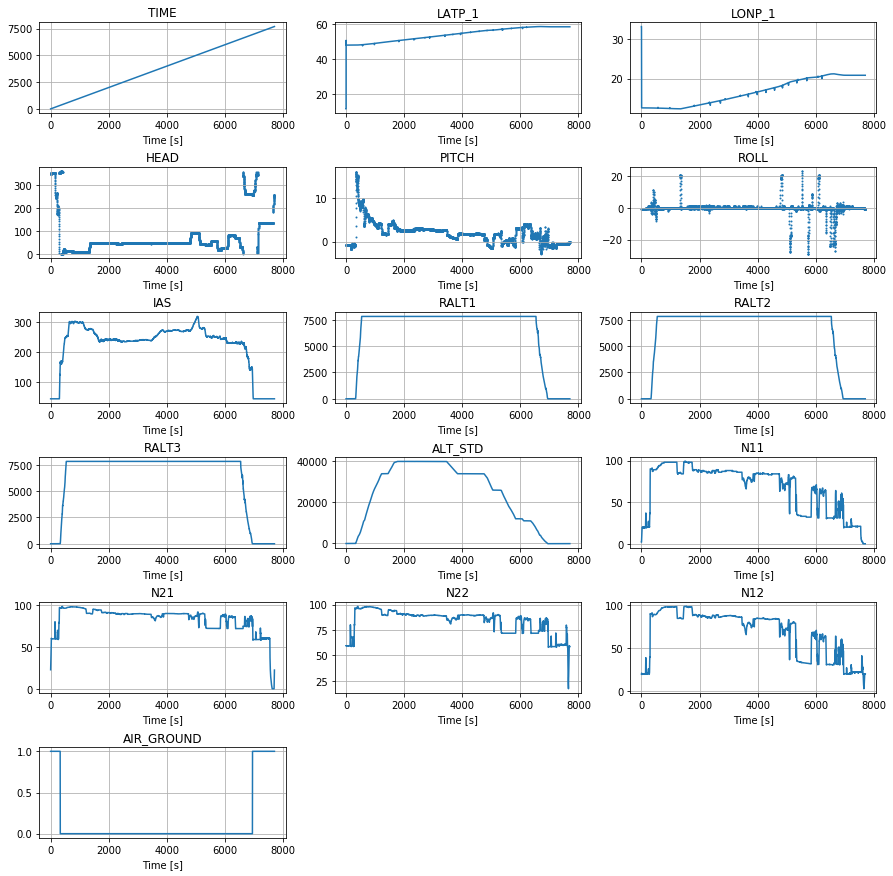

In [178]:

# we will use this variable each time we are using flights[0]
flight = flights1[0]

# some of our feature are filled with nan values and needs interpolation
flight[['RALT1','RALT2','RALT3']] = flight[['RALT1','RALT2','RALT3']].interpolate(limit_direction='both')

# some features are not continous, and are best plotted as scatter plots
scatter = ['HEAD','PITCH','ROLL']

# all column names
columns = flight.columns.values

# count for subplot index
count = 1

plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace = 0.6)

# plot each column with the time
for column in columns:
    plt.subplot(6,3,count)
    
    # check if feature are to be scattered or plotted regularly
    if column in scatter:
        plt.scatter(flight['TIME'],flight[column],s=1)
    else:
        plt.plot(flight['TIME'],flight[column])
        
    plt.title(column)
    plt.xlabel('Time [s]')
    count +=1
plt.show()

Your comment here:

It is beneficial to interpolate the variables with missing values, i.e. NaN-values, given that we need 1 Hz resolution. Variables with abrupt changes are better visualised as scatter plots rather than line plots. These variables are HEADING, PITCH and ROLL. 

If it is interesting to see the variables for a given flight, it is more informative to view the set of values for all flights in order to understand what are the significant/normal values and what are those which are abnormal.

<div class="alert alert-info">
<h3><div class="label label-default">Question 2</div>  <div class="label label-info">Visualize N21 variable for all flights</div></h3>
<br>
For the <code>N21</code> variable, for example, display all of the flights on the same figure. Use alpha parameter to add transparency to your plot. Is there any pattern? Comment the variabilities you observe.
</div>

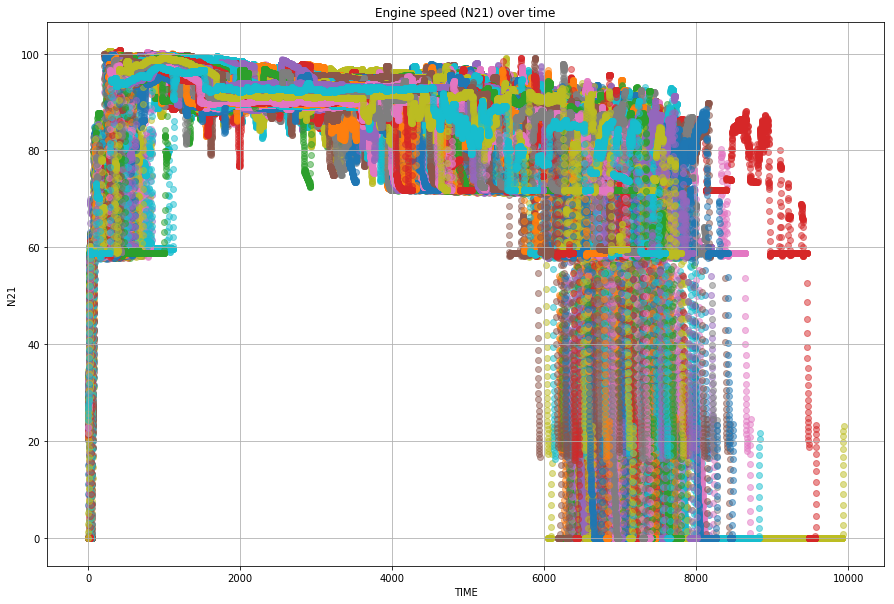

In [171]:
plt.figure(figsize=(15,10))
plt.title('Engine speed (N21) over time')
plt.xlabel('TIME')
plt.ylabel('N21')

for i in range(len(flights1)):
    data = flights1[i]["N21"]
    time = flights1[i]['TIME']
    plt.scatter(time,data,alpha = 0.5)
    
plt.show()

Your comment here:

We observe that every flight start with low engine speed, which is consistant with taxing on the runway. It is then increased dramatically and kept high until around 1800 seconds while the plane is climbing. While at cruising altitude the engines are kept at around 90 per cent thrust to save fuel. Finally, the reductions in engine speed comes at around 6000-9500 seconds depending on how long the flight took. 

Some variables must be analyzed together, such as latitude and longitude, otherwise the visualization information will be incomplete, we could be missing something.

<div class="alert alert-info">
<h3><div class="label label-default">Question 3</div>  <div class="label label-info">Visualize latitude against longitude for all flights</div></h3>
<br>
Display the trajectories (<code>LONP_1</code>, <code>LATP_1</code>) of the first 20 flights, that is <code>flights1[:20]</code>. What do you see? Keep in mind that the data during the beginning of the recording may be abnormal. What insight do you lose when you plot <code>LONP_1</code> against <code>LATP_1</code> ?
</div>

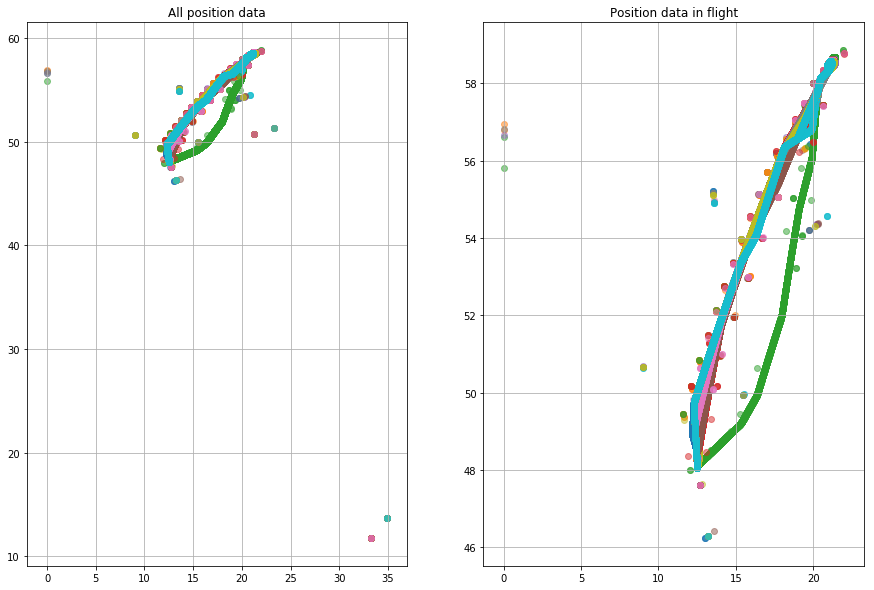

In [165]:
plt.figure(figsize=(15,10))

# left plot 
plt.subplot(121)
plt.title("All position data")
plt.xlabel("LONP_1")
plt.ylabel('LATP_1')
for i in range(20):
    lonp = flights1[i]["LONP_1"]
    latp = flights1[i]['LATP_1']
    plt.scatter(lonp,latp,alpha = 0.5)
    
# right plot
plt.subplot(122)
plt.title("Position data in flight")
plt.xlabel("LONP_1")
plt.ylabel('LATP_1')
for i in range(20):
    lonp = flights1[i].query('AIR_GROUND == 0')["LONP_1"]
    latp = flights1[i].query('AIR_GROUND == 0')['LATP_1']
    plt.scatter(lonp,latp,alpha = 0.5)
    
plt.show()


Your comment here:

We use the boolean AIR_GROUND variable to filter out data points the the planes are on the ground. We observe that planes are heading from one city to another and generally along the same path, except the green one. There are still some outliers in the variables, which we assume to be measurement errors. These measurement errors also seem to be clustered together. We do not have a good explaination on why this may be. 

Keep in mind that our goal is to understand the nature and the inherent problems of our data, and its features. Proceed with the visual analysis of the data, looking at different features.

<div class="alert alert-info">
<h3><div class="label label-default">Question 4</div>  <div class="label label-info">Recap variables that require pre-processing</div></h3>
<br>
Based on your observations as for now, what are the variables requiring processing? For each of these variables, specify the necessary pre-processing required prior to perform data analysis.
</div>

Your answer here:

All NaN variables should be interpolated. The longitude and latitude is generally not reliable when the plane is on the ground and should be ignored when doing analysis.

It is important to undestand the links between variables, to understand how a system works.

<div class="alert alert-info">
<h3><div class="label label-default">Question 5</div>  <div class="label label-info">Correlation between variables</div></h3>
<br>
 Compute the correlation of each normalized variables with any others for one flight.
Compute delay and max value for each pair of variables.
What happens if you do not normalize ?
What are the most correlated variables or group of variables ?
Can you comment about the delay between variables ?
</div>

In [144]:
from scipy import signal
def correlation(x,y):
    all_correlations = signal.correlate(x,y)
    maximum_correlation = np.max(all_correlations)
    delay = np.argmax(all_correlations)-x.shape[0]+1
    return maximum_correlation, delay


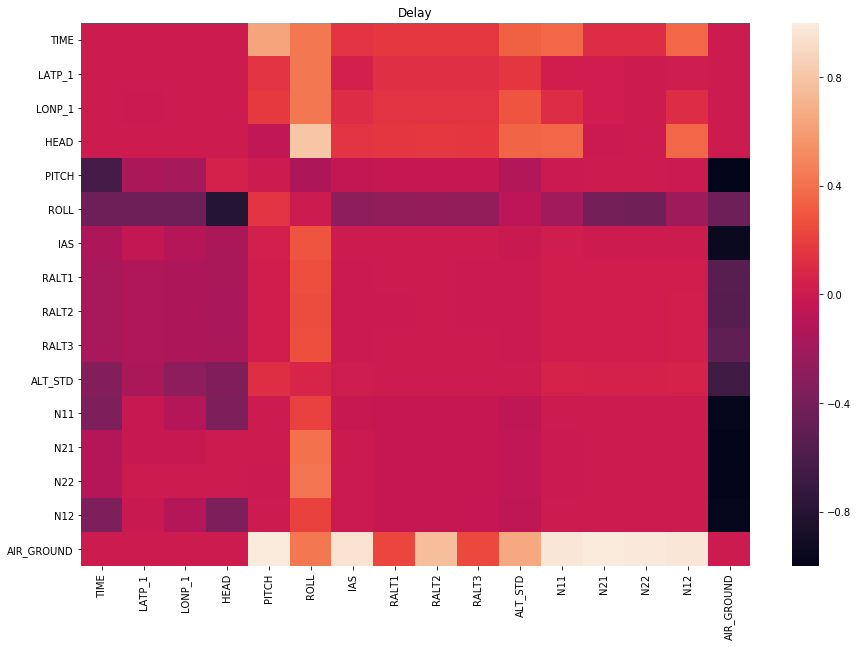

Text(0.5,1,'Correlation')

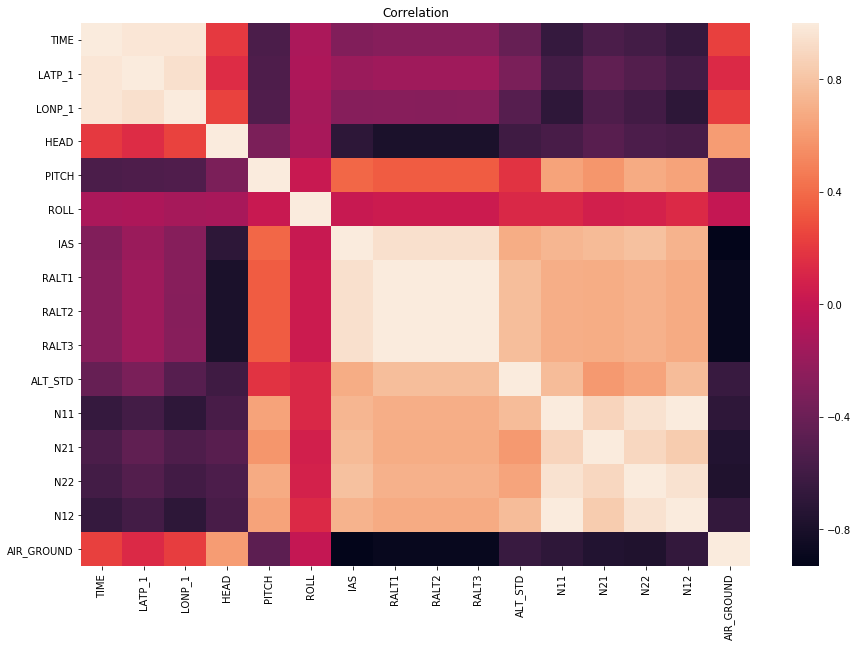

In [158]:
delays = np.zeros((len(columns),len(columns)))

for i in range(len(columns)):
    column1 = columns[i]
    for j in range(len(columns)):
        column2 = columns[j]
        
        x = flight[column1].values
        y = flight[column2].values
        maximum_correlation, delay = correlation(x,y)
        delays[i,j] = delay

# find maximum delay value
max_delay = np.amax(delays)

# delay heatmap
plt.figure(figsize=(15,10))

# normalize delays and place in dataframe
delayDF  = pd.DataFrame(data=delays/max_delay,columns=columns)

# set columns as indices for heatmap display
delayDF.index = columns

sns.heatmap(delayDF)
plt.title('Delay')
plt.show()

# correlation heatmap
plt.figure(figsize=(15,10))
sns.heatmap(flight.corr())
plt.title('Correlation')


Your comment here:

Without normalization some of the variables are much bigger than the others and it is hard to make comparisons. The altitude sensors are very highly correlated since they are just located at different parts of the airplane. The engine rpms are also highly correlated since both fans in the same engine mostly rotates at proportional speeds, and it is rare to have one engine reving higher than the other.
Both longitude and latitude increase over time implying that the plane is heading in the northeastern direction. This also give a high positive correlating between TIME, LATP_1 and LONP_1.

We observe that the delay is symetric about the diagonal but that the delay changes direction. This make sense, if the delay between A and b is 10, the delay between B and A will be -10. We can see that the flight changes HEAD and ROLL at the same time, this typically happens right after take-off. 


## Pre-processing

Data pre-processing is essential, in order to separate the errors due to measurement from "normal" data variability, which is representative of the phenomenon that interests us.

<div class="alert alert-info">
<h3><div class="label label-default">Question 6</div>  <div class="label label-info">Smooth and filter out abnormal data in trajectories (LATP_1 and LONP_1)</div></h3>
<br>
Filter the flight trajectories (<code>LATP_1</code> and <code>LONP_1</code> variables). You can focus on the first 20 flights, that is <code>flights1[:20]</code>. Display the trajectories before and after smoothing.
</div>

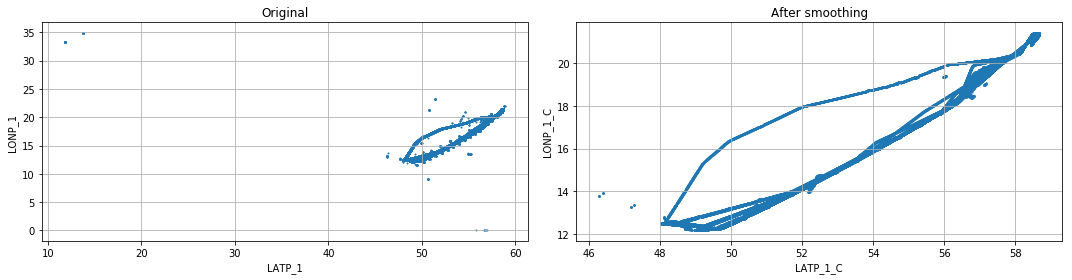

In [163]:

# this is a template code, fill in the blanks, or use your own code

# Only work with the first few flights
fs = flights1[:20]

# Set up the figure to plot the trajectories before (ax0) and after smoothing (ax1)
fig, axarr = plt.subplots(1, 2)
fig.set_figwidth(15)
ax0, ax1 = axarr

# use mean of window of 40 for better stability
for f in fs:
    f["LATP_1_C"] = f.LATP_1.rolling(window=40).mean() # FILL IN THE BLANKS
    f["LONP_1_C"] = f.LONP_1.rolling(window=40).mean() # FILL IN THE BLANKS

for f in fs:
    f.plot(kind="scatter", x="LATP_1", y="LONP_1", s=1, ax=ax0,title='Original') # plot raw trajectory
    f.plot(kind="scatter", x="LATP_1_C", y="LONP_1_C", s=1, ax=ax1,title='After smoothing') # plot smoothed trajectory
    
    
fig.tight_layout()

<div class="alert alert-info">
<h3><div class="label label-default">Question 7</div>  <div class="label label-info">Pre-process HEAD, get rid off discontinuities</div></h3>
<br>
Angles are special variables because they "cycle" over their range of values. The <code>HEAD</code> variable shows artificial discontinuities: your goal is to eliminate (filter out) such discontinuities. The angle may no longer be between 0 and 360 degrees after the transformation but it will come very handy for some analysis later. Display the data before and after transformation. You can focus on one flight, for example <code>flights1[0]</code>.
</div>

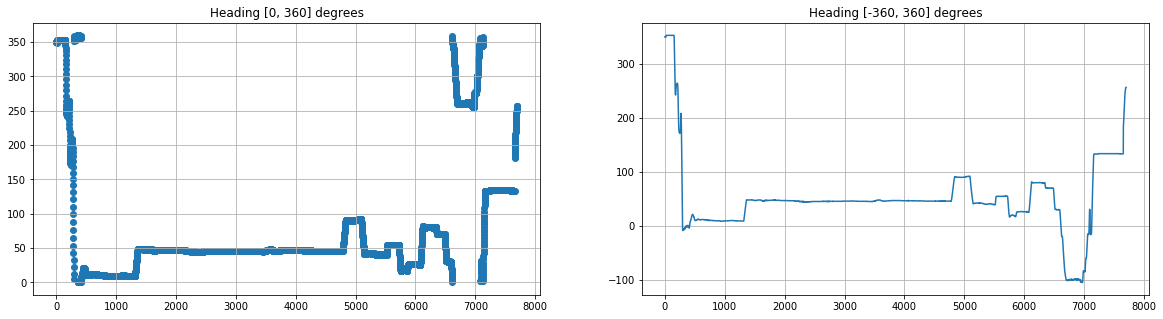

In [162]:
# your code goes here ...
head = flight['HEAD']
time = flight['TIME']
plt.figure(figsize=(20,5))

# left plot
plt.subplot(121)
plt.title('Heading [0, 360] degrees')
plt.scatter(time,head)

# right plot
plt.subplot(122)
plt.title('Heading [-360, 360] degrees')

# convert degrees to rad, unwrap, convert back 
head = np.unwrap(head*np.pi/180)*180/np.pi

plt.plot(time,head)

plt.show()

Your comment here:

It is possible for the plane to turn more than 360 degrees. The sensor only stores data on the interval [0, 360] degrees. We used an unwrap to change the interval into [-360, 360] and thus removing the discontinuities. It is clealer to use plot instead of scatter when the data is continuous.

<div class="alert alert-info">
<h3><div class="label label-default">Question 8</div>  <div class="label label-info">All data on the same time base</div></h3>
<br>When we make an analysis, it is important to have the maximum of information. However, for any flight, you can see that there is three RALT (<code>RALT1</code>, <code>RALT2</code>, <code>RALT3</code>). They are not at the same sampling rate.
Use interpolation on one flight, for example <code>flights1[0]</code>,to have them at the same sampling rate of 1Hz. Then, merge your results. Can you comment on the method you used ?
</div>

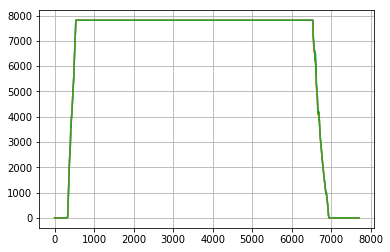

In [68]:
from scipy import interpolate

ralt1 = flight['RALT1']
ralt2 = flight['RALT2']
ralt3 = flight['RALT3']
time = flight['TIME']
plt.plot(time,ralt1)
plt.plot(time,ralt2)
plt.plot(time,ralt3)
plt.show()

Your comment here:

We removed the NaNs and used interpolation in both directions to fill in the blank spots. This was done in Qestion 1.


<h1><div class="label label-success">Part 2: Analysis</div></h1>

We now turn to the data analysis task. In this part, we will use a **clean** dataset, which has been prepared for you; nevertheless, the functions you developed in the first part of the notebook can still be used to visualize and inspect the new data. Next, we display the schema of the new dataset you will use:

| var | description |
|:-----:|:-------------:|
| TIME   |elapsed seconds|
| **LATP_C** | **Latitude (°), Corrected**|
| **LONP_C** | **Longitude (°), Corrected**|
| **RALT_F** | **Radio Altitude (feet), Fusioned**|
| **ALT_STD_C** | **Relative Altitude (feet), Corrected**|
| **HEAD_C** | **head (°), Corrected**|
| **HEAD_TRUE** | **head (°), without discontinuities**|
| **PITCH_C** | **pitch (°), Corrected**|
| **ROLL_C** | **roll (°), Corrected**|
| **IAS_C** | **Indicated Air Speed (m/s), Corrected**|
| N11 | speed N1 of the first engine (% of tr/min)|
| N21 | speed N2 of the first engine (% of tr/min)|
| N12 | speed N1 of the second engine (% of tr/min)|
| N22 | speed N2 of the second engine (% of tr/min)|
| AIR_GROUND | status in the air (Boolean)|

<div class="label label-primary">Execute the cell below to load the data for part 2</div>

In [4]:
num_flights = 780
flights2 = load_data_from_directory(BASE_DIR + "part2/flights/", num_flights)
for f in flights2:
    l = len(f)
    new_idx = pd.date_range(start=pd.Timestamp("now").date(), periods=l, freq="S")
    f.set_index(new_idx, inplace=True)
    
flight0 = flights2[0]

There are 780 files in total
We process 780 files


In this part, we will try to modelize a time series with simple models. In particular, we will look at the landing, and the N1 variable.

<div class="label label-primary">
 First, look at the variables for the flight 0, by executing the following code.
</div>

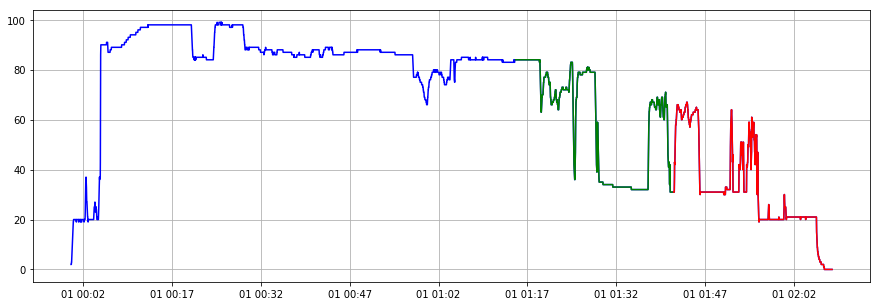

In [47]:
plt.figure(figsize=(15,5))
plt.plot(flight0['N11'], 'b')
index_start = 4500
tomodel = flight0['N11'][index_start:index_start+1600]
topredict = flight0['N11'][index_start+1600:index_start+3600] 
plt.plot(tomodel, 'g')
plt.plot(topredict, 'r')

<div class="alert alert-info">
<h3><div class="label label-default">Question 9</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
Is it stationary ? The augmented Dickey-Fuller test is a popular test to test the null hypothesis that a time series sample is non-stationary. Use this test to confirm what you observed.
</div>

In [8]:
import scipy.stats.stats as stats
from statsmodels.tsa.stattools import adfuller
# your code goes here

DFtest_brut = adfuller(tomodel)
print('Augmented D-F test before detrending:')
print('p-value = ' + str(DFtest_brut))

Augmented D-F test before detrending:
p-value = (-1.8011809767727869, 0.379875529253237, 10, 1589, {'1%': -3.434472023496696, '5%': -2.8633606295952383, '10%': -2.5677392685830567}, 2623.3195196470047)


With a p-value of 0.38 we cannot reject the null hypothesis that the time series is non-stationary at 5 per cent significance level. We can also see this from the graph as there is a clear falling trend. The falling trend implies that the mean changes with respect to time, which again implies a non-stationary time series.  

<div class="alert alert-info">
<h3><div class="label label-default">Question 10</div>  <div class="label label-info">Modelization of time series</div></h3>
<br>
We may want to detrend the time serie. Fit a polynom or order 3 to the sequence <code>tomodel</code>, remove the trend and look at the Dickey-Fuller test again. Should you have used an higher degree polynomial? What would be the issue of a high degree polynomial when trying to do prediction of future sample?

</div>

detrended mean:  -4.959019861416891e-12
Augmented D-F test after detrending:
p-value = (-2.559623149568985, 0.10163274183912563, 10, 1589, {'1%': -3.434472023496696, '5%': -2.8633606295952383, '10%': -2.5677392685830567}, 2621.6806318113177)


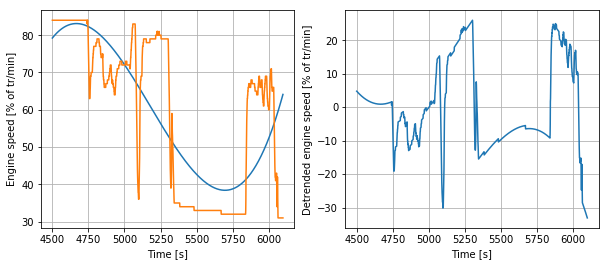

In [89]:
# https://machinelearningmastery.com/time-series-trends-in-python/

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
# Your code goes here

time_tomodel = flight0['TIME'][index_start:index_start+1600]
time_topredict = flight0['TIME'][index_start+1600:index_start+3600]

model = LinearRegression()
poly = PolynomialFeatures(3)

tomodel_transformed = poly.fit_transform(time_tomodel.reshape(-1,1))
topredict_transformed = poly.fit_transform(time_topredict.reshape(-1,1))

model.fit(tomodel_transformed,tomodel)
preds_tomodel = model.predict(tomodel_transformed)
preds = model.predict(topredict_transformed)

tomodel_detrend = tomodel - preds_tomodel


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(time_tomodel,preds_tomodel)
plt.plot(time_tomodel,tomodel)
plt.xlabel('Time [s]')
plt.ylabel('Engine speed [% of tr/min]')

plt.subplot(1,2,2)
plt.plot(time_tomodel, tomodel_detrend)
plt.xlabel('Time [s]')
plt.ylabel('Detrended engine speed [% of tr/min]')

print("detrended mean: ", np.mean(tomodel_detrend))
DFtest_corrected = adfuller(tomodel_detrend)
print('Augmented D-F test after detrending:')
print('p-value = ' + str(DFtest_corrected))

We have removed the trend by using a third degree polynomial. The p-value of 0.10 is still to high to reject the null hypthesis at 5% significance level. We also tried with polynomial degrees 1 to 8. None of the were able to reject the null hypothesis at 5 % significance level. Also increasing the polynomial degree would increase the problem of overfiting even further.


Augmented D-F test after detrending:
p-value = (-7.751530986374742, 9.990192250247087e-12, 22, 1577, {'1%': -3.4345034408379527, '5%': -2.863374496477375, '10%': -2.567746652650719}, 512.2739608187971)


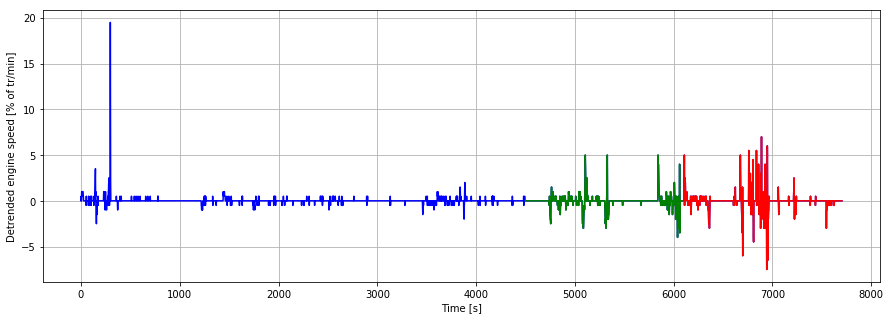

In [90]:
tomodel_detrend = np.gradient(tomodel)
topredict_detrend = np.gradient(topredict)
flight0_detrend = np.gradient(flight0['N11'])

plt.figure(figsize=(15,5))
plt.plot(flight0['TIME'],flight0_detrend, 'b')
plt.plot(time_tomodel,tomodel_detrend, 'g')
plt.plot(time_topredict,topredict_detrend, 'r')
plt.xlabel('Time [s]')
plt.ylabel('Detrended engine speed [% of tr/min]')
mean = np.mean(flight0_detrend)

DFtest_corrected = adfuller(tomodel_detrend)
print('Augmented D-F test after detrending:')
print('p-value = ' + str(DFtest_corrected))

As an alternative, we tried detrending the time series by differentiation. This was highly successful and the null hypothesis could easily be rejected at any reasonable significance level. (p = 9.99e-12)

<div class="alert alert-info">
<h3><div class="label label-default">Question 11</div>  <div class="label label-info">Prediction using polynomial</div></h3>
<br>
We want to predict what will be our next N11 in the next time steps. Use the polynom to predict the end of <code>tomodel</code>. Compare to <code>topredict</code>. What can you say ? What could you do to improve your prediction ?
</div>


Text(0,0.5,'Predicted engine speed [% of tr/min]')

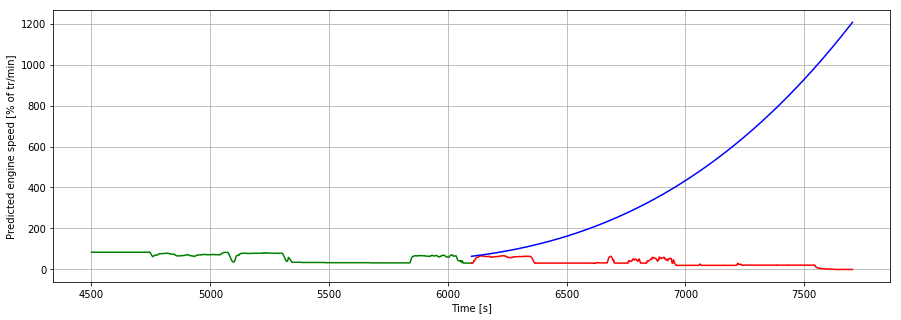

In [91]:
# Your code goes here
plt.figure(figsize=(15,5))
index_start = 4500
plt.plot(time_tomodel,tomodel.values, 'g')
plt.plot(time_topredict,topredict.values, 'r')
plt.plot(time_topredict,preds, 'b')
plt.xlabel('Time [s]')
plt.ylabel('Predicted engine speed [% of tr/min]')

We observe that, as expected, the polynomial of order 3 overfits the training data and thus grossly mispredicts the true values. Some ideas to improve our model is to look at data for more than one flight when building the model. Another idea is to use more features than just time.

We will now see if we can model the time series using auto-regressive / moving-average models.
The **ARIMA** technique (Auto-Regressive Integrated Moving Average) allows modeling and forecasting of time series. The parameters of an ARIMA model are often noted (p,d,q) where:
- p is the number of auto-regressive terms (AR), e.g. if p=3, x(t) will be determined from x(t-1), x(t-2) and x(t-3)
- d is the number of differences to take before obtaining a stationary time series
- q is the number of moving average (MA) terms.

Autocorrelation (ACF) and partial autocorrelation (PACF) plots are a usefull tool to identify the values for *p* and *q*. The autocorrelation describes the correlation of observations with observations at previous time steps (or lags).
Partial autocorrelation does the same thing but for lag *k* removes the effect of correlations due to the terms at shorter lags.

<div class="label label-primary">
Plot the ACF and PACF of the time series.
</div>


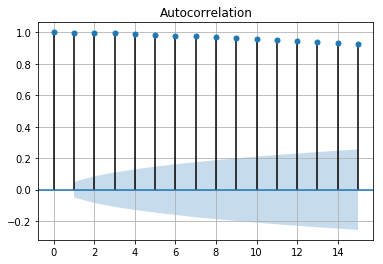

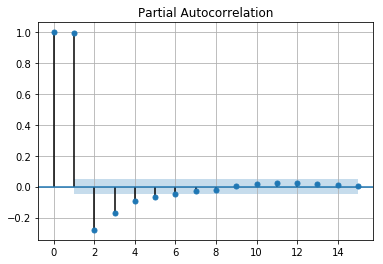

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
plot_acf(tomodel,lags=15)
plt.show()
plot_pacf(tomodel,lags=15)
plt.show()

On thoses plots you can observe blue shaded regions, those are confidence interevals (set to a 95% default value). Values of ACF or PACF outside of this region are likely to be correlations and not noise.

Observe the shape of the two plots:

    ACF plot decays gradually
    PACF shows a statistically significant spike at lag 1, 2, 3, 5 and none beyond lag 5

This is the sign of an auto-regressive AR(5) process.

To sum up:

    the signal is not stationary, so we can try to have d=1
    it seems to be an AR(5) process so p=5 and q=0

<div class="alert alert-info">
<h3><div class="label label-default">Question 12</div>  <div class="label label-info">Prediction using ARIMA</div></h3>
<br>

Now, train an ARIMA(5,1,0) model on the data, and then, use it to predict the next steps of <code>tomodel</code>. Compare it to <code>topredict</code>
</div>

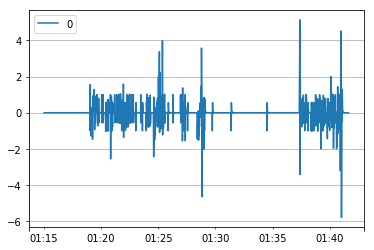

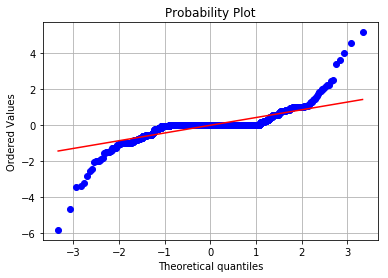

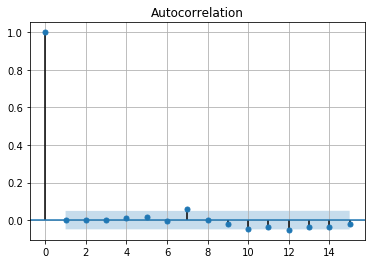

                 0
count  1599.000000
mean     -0.007839
std       0.552096
min      -5.802284
25%       0.000000
50%       0.000000
75%       0.000000
max       5.141680


In [24]:
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import probplot

ARmodel = ARIMA(tomodel,order=(5,1,0))
ARfitres = ARmodel.fit(trend='nc')

residuals = pd.DataFrame(ARfitres.resid)
residuals.plot()
plt.show()

probplot(ARfitres.resid, dist='norm',plot=plt)
plt.show()

plot_acf(ARfitres.resid,lags=15)
plt.show()

print(residuals.describe())

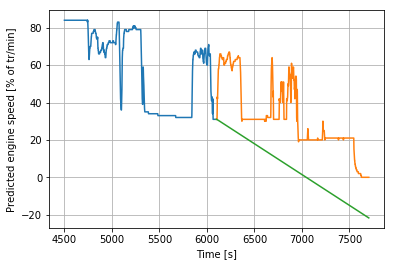

In [92]:
model = ARIMA(tomodel,order=(5,1,0))
model_res = model.fit(disp=0)
newval = model_res.forecast(len(topredict))[0]
plt.plot(time_tomodel,tomodel)
plt.plot(time_topredict,topredict)
plt.plot(time_topredict,newval)
plt.xlabel('Time [s]')
plt.ylabel('Predicted engine speed [% of tr/min]')
plt.show()

We tried two models. We now want to compare them in a more scientific way, to select the best model.
<div class="alert alert-info">
<h3><div class="label label-default">Question 13</div>  <div class="label label-info">Compare models</div></h3>
<br>
Compute the mean squared error to compare the two models. Comment on the results, then comment on the two approaches.
</div>

In [76]:
# Your code goes here
from sklearn.metrics import mean_squared_error
mse_poly = mean_squared_error(topredict,preds)
mse_arima = mean_squared_error(topredict,newval)
print('Mean squared error (3rd degree polynomial): ', mse_poly)
print('Mean squared error (ARIMA): ', mse_arima)

Mean squared error (3rd degree polynomial):  64951.6581006227
Mean squared error (ARIMA):  824.5784985936658


We see that the MSE of the ARIMA is much lower than the 3rd degree polynomial due because of overfitting. However, it the ARIMA model still has the issue of predicting the shutdown of the enging much sooner than what actually is the case. The ARIMA model works by analyzing the signal in the z-domain and we were a bit surprised just to see a straight line as output. To investivate this further we plotted the frequency content of the training data.

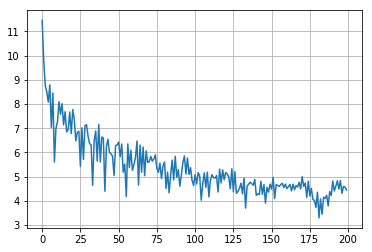

In [77]:
fft_tomodel = np.fft.fft(tomodel)
plt.plot(np.log(abs(fft_tomodel)[:200]))
#The absolute values of the axes are irrelevant. We are just looking for peaks in the frequency domain.

As we can see there are no strong signle frequency components except the DC-component (it is not centered around 0). In other words there are no regular cyclic repititions in the engine speed signal and thus there will not be any frequency components above 0 Hz in the ARIMA model either. 

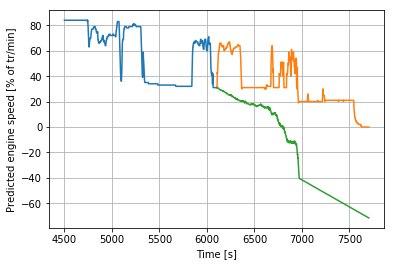

3137.7201281582306


In [93]:
#Using more features to predict N11
model = LinearRegression()
X = flight0[["ALT_STD_C","RALT_F","IAS_C","TIME"]]
X_model = X.iloc[index_start:index_start+1600].values
X_pred = X.iloc[index_start+1600:index_start+3600].values
y_pred = topredict
y_model = tomodel
model.fit(X_model,y_model)
preds = model.predict(X_pred)
plt.plot(time_tomodel,tomodel)
plt.plot(time_topredict,topredict)
plt.plot(time_topredict,preds)
plt.xlabel('Time [s]')
plt.ylabel('Predicted engine speed [% of tr/min]')
plt.show()
print(mean_squared_error(preds,y_pred))

We see that using more features does not really work too well as the landing (shutdown of the engine) is predicted even earlier than in the ARIMA model. It will be better to use the history of multiple earlier flights and average them to predict the engine speed. We have started working on this below.

In [79]:
#Using more features on 100 flights to predict N11

flights = flights2[1:101]
X = np.mean([flight[["ALT_STD_C","RALT_F","IAS_C","TIME"]].iloc[index_start:index_start+3600].values for flight in flights],axis=0)
y = np.mean([flight['N11'].iloc[index_start:index_start+3600].values for flight in flights],axis=0)
plot()



ValueError: operands could not be broadcast together with shapes (2280,4) (2488,4) 